https://medium.com/@adrianovalexey/раз-и-навсегда-как-автоматизировать-построение-когорт-с-python-и-pandas-74f2c38dd3f7

На вход подаем файл содержащий столбцы со значениями:

* Client_ID — идентификаторы клиентов
* OrderDTE — содержит для клиентов даты целевых действий(покупка, публикация, твит, шер итп.), по которым будете строить когорту. Обратите внимание на формат.
* Revenue — показывающее сумму выручки от операции.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

# это чтобы графики строились непосредственно в блокноте iPython
%matplotlib inline 

# читаем файл
df = pd.read_excel('finance_10-2018_for_cohorts.xlsx')

df['firstPaymentDTE'] = df["Дата платежа (поступления, аванса)"].apply(lambda x: pd.to_datetime(x))

# Если считать по платежам, используй первую строчку ниже (из следующих трех). Если считать по учтенным в бухгалтерии доходам - вторую и третью. Не используемые строчки - закомментируй.
df = df.rename(index = str, columns={"ID клиента": "ClientID", "Дата платежа (поступления, аванса)": "orderDTE", "Сумма платежа": "Revenue"})
# df = df.rename(index = str, columns={"ID клиента": "ClientID", "Расчетный период": "orderDTE", "Стоимость оказанных услуг за расчетный период, руб.": "Revenue"})
# df['orderDTE'] = df['orderDTE'].apply(lambda x: x.strftime('%Y-%m'))

df.head()


,ClientID,ФИО клиента,Наименование оказанных услуг,orderDTE,"Дата возврата платежа (поступления, аванса)",Валюта начислений,Revenue,Номер заказа в системе,Номер заказа РБС,Количество оплаченных занятий,Стоимость одного занятия,Текущий остаток,Расчетный период,"Стоимость оказанных услуг за расчетный период, руб.","Остаток на конец отчетного периода, руб.",firstPaymentDTE
nan,8,Анатолий Обухов,1 занятие,2018-05-10 15:51:30,NaT,643,100,59,837f1926-c978-71cc-837f-19260007a120,1,100.0,100.0,2018-05-01,0.0,100.0,2018-05-10 15:51:30
nan,8,Анатолий Обухов,1 занятие,2018-05-10 15:58:19,2018-05-11 09:59:36,643,100,61,b23ccb93-5ad6-78b5-b23c-cb930007a120,1,100.0,100.0,2018-05-01,0.0,100.0,2018-05-10 15:58:19
nan,8,Анатолий Обухов,1 занятие,2018-05-21 13:39:05,NaT,643,6,95,1c976ac8-6c24-7f16-1c97-6ac80007a120,1,6.0,6.0,2018-05-01,0.0,6.0,2018-05-21 13:39:05
nan,8,Анатолий Обухов,1 занятие,2018-05-21 14:00:44,NaT,643,6,96,1ee506b7-470f-71db-1ee5-06b70007a120,1,6.0,6.0,2018-05-01,0.0,6.0,2018-05-21 14:00:44
nan,8,Анатолий Обухов,1 занятие,2018-05-22 08:52:28,NaT,643,6,102,e9971f5e-cf74-7e42-e997-1f5e0007a120,1,6.0,6.0,2018-05-01,0.0,6.0,2018-05-22 08:52:28


In [96]:
# Добавим столбец OrderPeriod для дальнейшей группировки данных
# df['OrderPeriod'] = df.orderDTE.apply(lambda x: x.strftime('%Y-%m'))
df['OrderPeriod'] = df.orderDTE.apply(lambda x: x[:7])
df.head()

,ClientID,ФИО клиента,Наименование оказанных услуг,orderDTE,"Дата возврата платежа (поступления, аванса)",Валюта начислений,Revenue,Номер заказа в системе,Номер заказа РБС,Количество оплаченных занятий,Стоимость одного занятия,Текущий остаток,Расчетный период,"Стоимость оказанных услуг за расчетный период, руб.","Остаток на конец отчетного периода, руб.",firstPaymentDTE,OrderPeriod
nan,8,Анатолий Обухов,1 занятие,2018-05-10 15:51:30,NaT,643,100,59,837f1926-c978-71cc-837f-19260007a120,1,100.0,100.0,2018-05-01,0.0,100.0,2018-05-10 15:51:30,2018-05
nan,8,Анатолий Обухов,1 занятие,2018-05-10 15:58:19,2018-05-11 09:59:36,643,100,61,b23ccb93-5ad6-78b5-b23c-cb930007a120,1,100.0,100.0,2018-05-01,0.0,100.0,2018-05-10 15:58:19,2018-05
nan,8,Анатолий Обухов,1 занятие,2018-05-21 13:39:05,NaT,643,6,95,1c976ac8-6c24-7f16-1c97-6ac80007a120,1,6.0,6.0,2018-05-01,0.0,6.0,2018-05-21 13:39:05,2018-05
nan,8,Анатолий Обухов,1 занятие,2018-05-21 14:00:44,NaT,643,6,96,1ee506b7-470f-71db-1ee5-06b70007a120,1,6.0,6.0,2018-05-01,0.0,6.0,2018-05-21 14:00:44,2018-05
nan,8,Анатолий Обухов,1 занятие,2018-05-22 08:52:28,NaT,643,6,102,e9971f5e-cf74-7e42-e997-1f5e0007a120,1,6.0,6.0,2018-05-01,0.0,6.0,2018-05-22 08:52:28,2018-05


In [97]:
#добавим индекс в dataFrame по ClientID
df.set_index('ClientID', inplace=True)

In [98]:
# Здесь тоже можно выбрать первую или вторую строчки в зависимости от чего учет. По платежам (авансам) - первая. По учету в бухгалтерии - вторая.

# df['JoinMonth'] = df.groupby(level=0)['orderDTE'].min().apply(lambda x: x.strftime('%Y-%m')) #добавим столбец JoinMonth
df['JoinMonth'] = df.groupby(level=0)['firstPaymentDTE'].min().apply(lambda x: x.strftime('%Y-%m')) #добавим столбец JoinMonth

df.reset_index(inplace=True) #переиндексируем df

df.insert(len(df.columns), "TotalOrders", 0, allow_duplicates=False) #создадим столбец в котором далее поместим количество заказов


In [99]:
df.tail()

,ClientID,ФИО клиента,Наименование оказанных услуг,orderDTE,"Дата возврата платежа (поступления, аванса)",Валюта начислений,Revenue,Номер заказа в системе,Номер заказа РБС,Количество оплаченных занятий,Стоимость одного занятия,Текущий остаток,Расчетный период,"Стоимость оказанных услуг за расчетный период, руб.","Остаток на конец отчетного периода, руб.",firstPaymentDTE,OrderPeriod,JoinMonth,TotalOrders
318,384,Алина Кровякова,3 занятия,2018-07-20 15:52:43,NaT,643,99,267,2adcc4a8-63fa-772d-2adc-c4a80007a120,5,19.8,99.0,2018-10-01,0.0,99.0,2018-07-20 15:52:43,2018-07,2018-07,0
319,91,Сергей Давыдов,3 занятия,2018-05-31 12:00:02,NaT,643,20,121,c7bdc234-6865-7563-c7bd-c2340007a120,5,4.0,20.0,2018-10-01,0.0,20.0,2018-05-31 12:00:02,2018-05,2018-05,0
320,91,Сергей Давыдов,3 занятия,2018-06-07 11:37:23,NaT,643,20,129,831407a6-4695-7ce4-8314-07a60007a120,5,4.0,20.0,2018-10-01,0.0,20.0,2018-06-07 11:37:23,2018-06,2018-05,0
321,195,Светлана Полякова,3 занятия,2018-06-30 13:28:43,NaT,643,20,190,50cfa5f9-e702-734d-50cf-a5f90007a120,5,4.0,20.0,2018-10-01,0.0,20.0,2018-06-30 13:28:43,2018-06,2018-06,0
322,83,Ярослав Смирнов,1 занятие,2018-05-21 14:58:31,NaT,643,6,98,e2c8a35c-261a-7f5e-e2c8-a35c0007a120,1,6.0,6.0,2018-10-01,0.0,6.0,2018-05-21 14:58:31,2018-05,2018-05,0


In [100]:
#свернем данные в когорты
grouped = df.groupby(['JoinMonth', 'OrderPeriod'])

# количество уникальных пользователей и общее количество заказов и выручка за период
cohorts = grouped.agg({'ClientID': pd.Series.nunique,
                       'TotalOrders': pd.Series.count, 
                       'Revenue': np.sum})

# переименуем некоторые столбцы для большего понимания
cohorts.rename(columns={'ClientID': 'TotalUsers',
                        'TotalOrders': 'TotalOrders'}, inplace=True)

# добавим ярлык для периодов
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

#посчитаем retention

# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinMonth','CohortPeriod'], inplace=True)

# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohorts['TotalUsers'].unstack(0)
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

Text(0,0.5,'% of Cohort Purchasing')

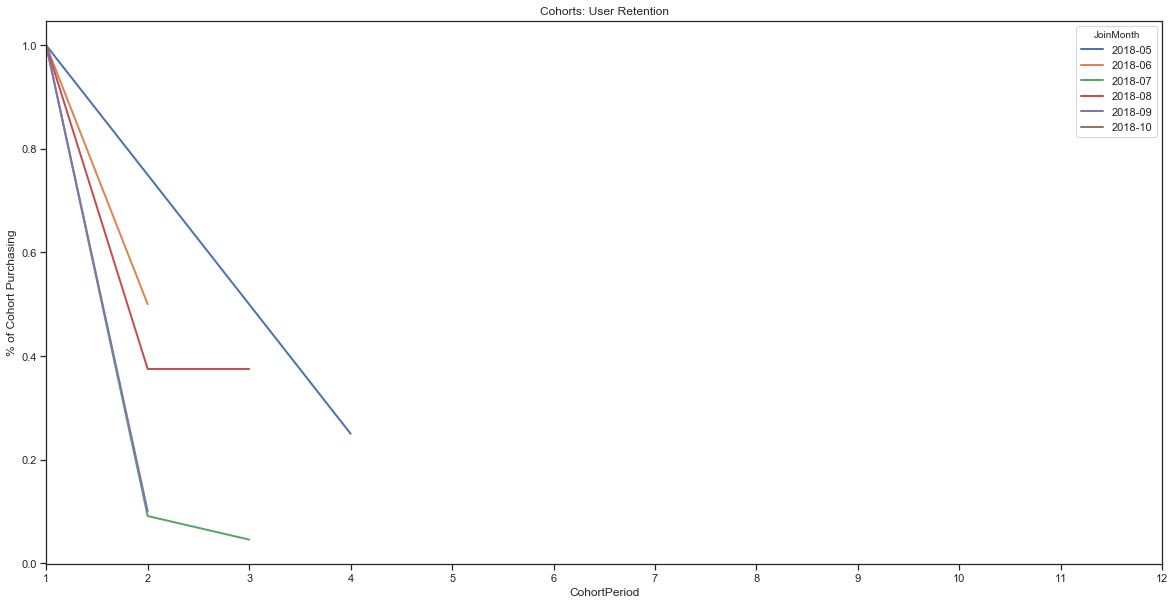

In [101]:

user_retention[['2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10']].plot(figsize=(20,10))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1)) # разбивка оси X
plt.xlim(1, 12) #ось X
plt.ylabel('% of Cohort Purchasing')

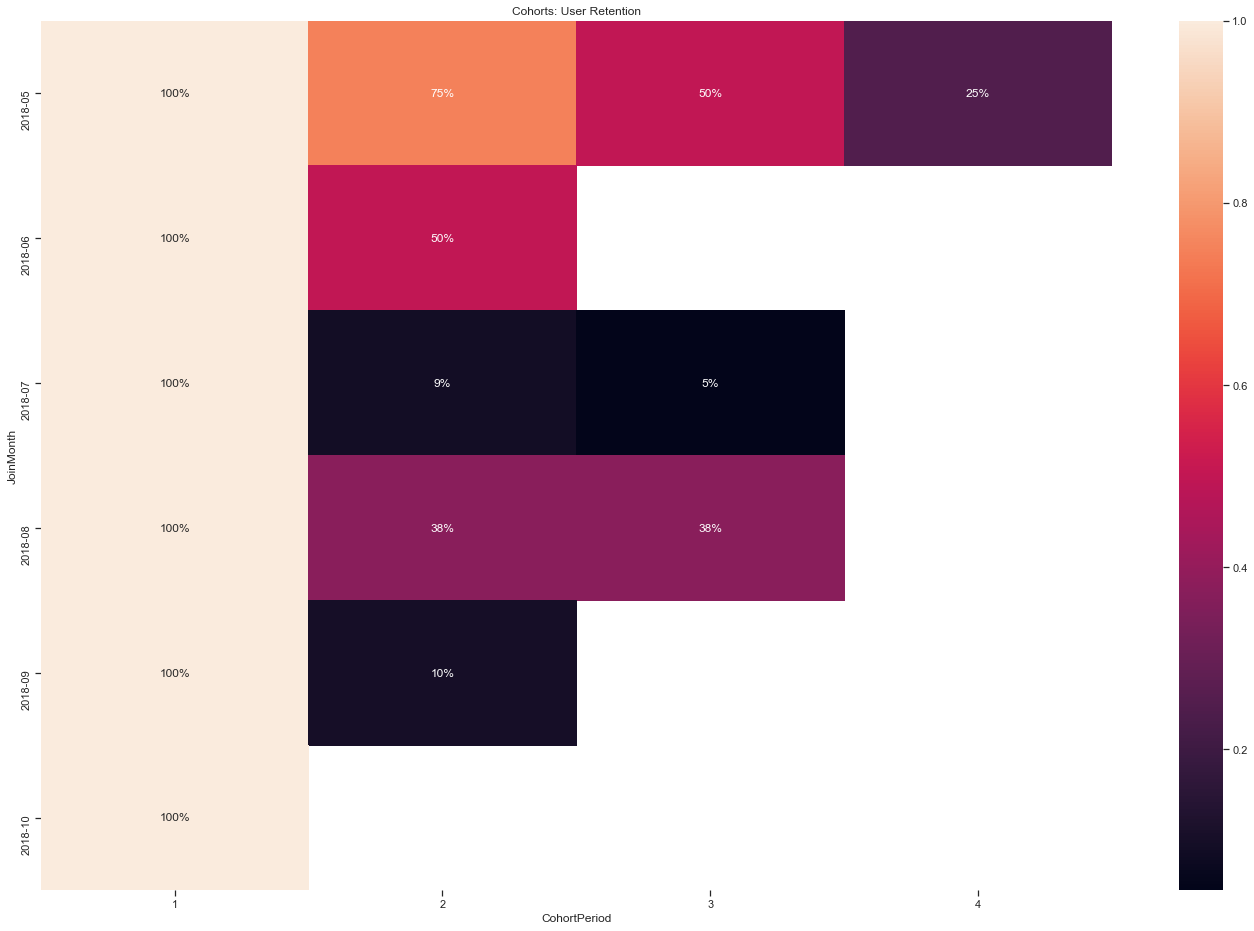

In [102]:

import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.00%')

Text(0,0.5,'% of Cohort Purchasing')

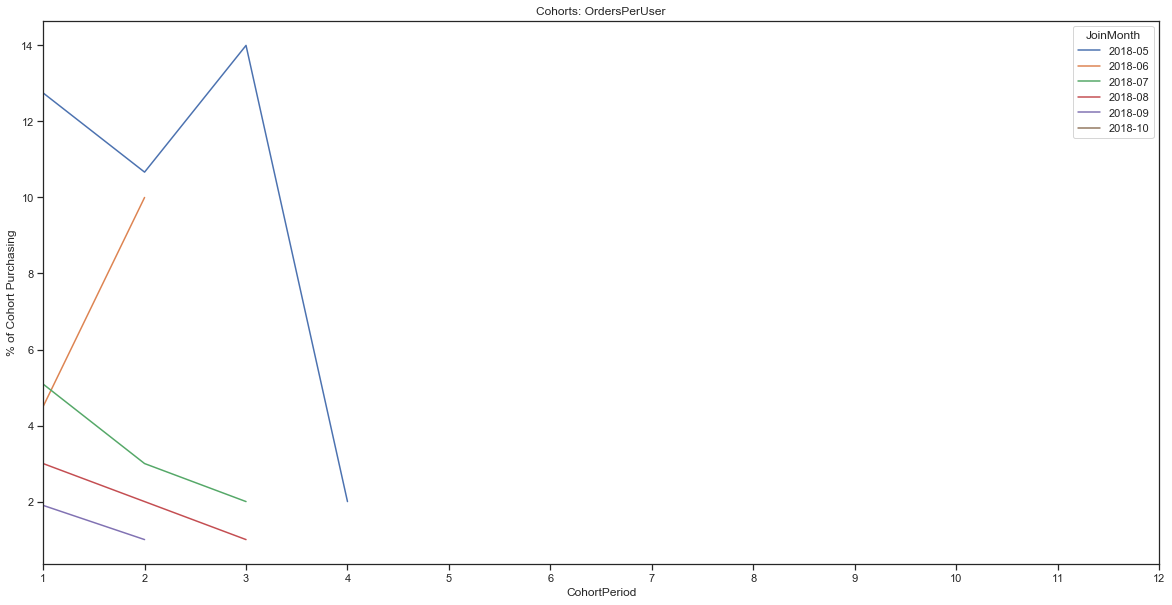

In [103]:

## Расчитаем частоту покупок по когортам
c = cohorts['TotalOrders']/cohorts['TotalUsers']
opc = c.unstack(0)

opc[['2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10']].plot(figsize=(20,10))
plt.title('Cohorts: OrdersPerUser')
plt.xticks(np.arange(1, 12.1, 1)) # разбивка оси X
plt.xlim(1, 12) #ось X
plt.ylabel('% of Cohort Purchasing')

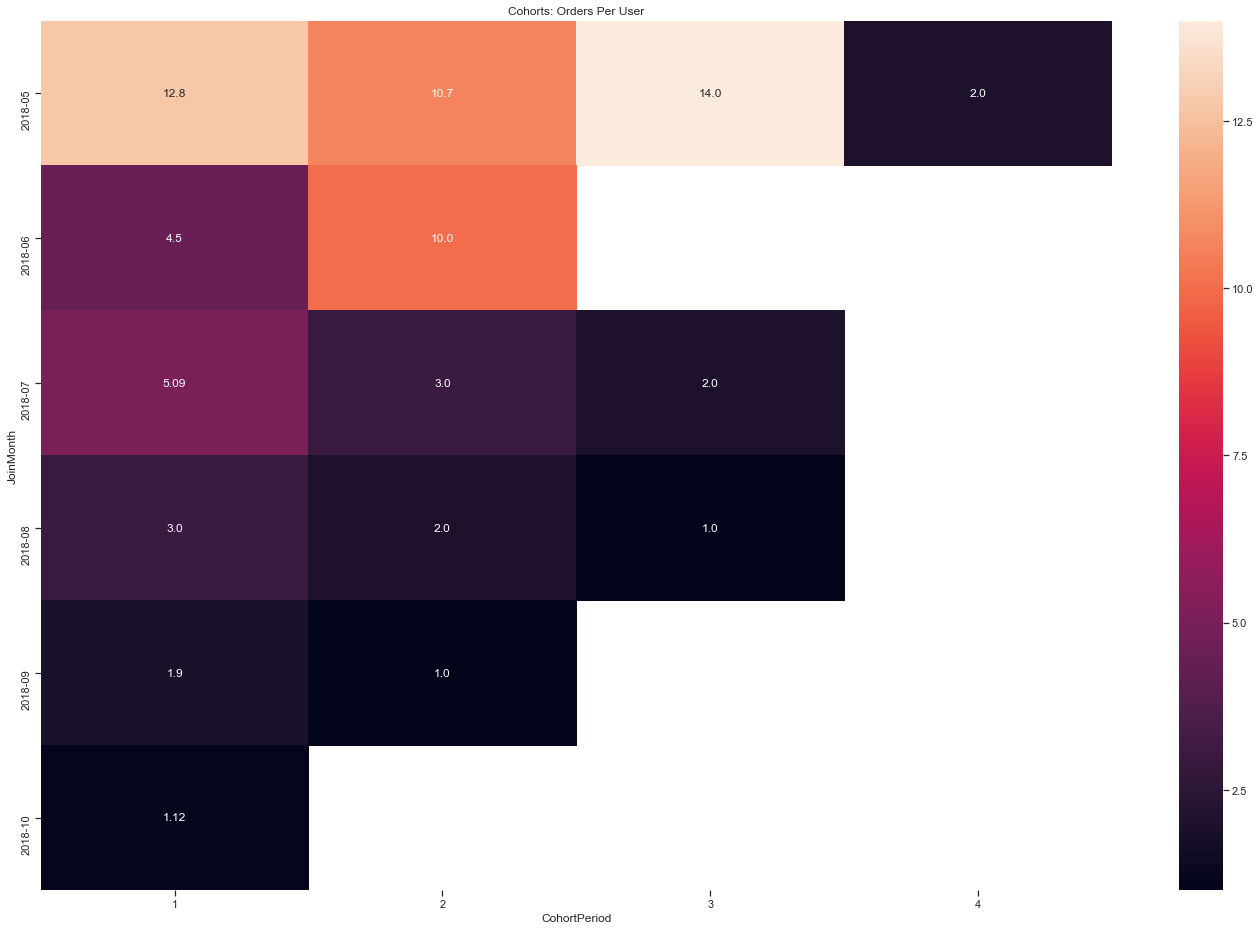

In [104]:

#cohortsOPC = cohorts['TotalOrders']/cohorts['TotalUsers']

import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: Orders Per User')
sns.heatmap(opc.T, mask=opc.T.isnull(), annot=True, fmt='.3')